In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dtype = torch.float32

## Generate

In [50]:
L, q = 45, 4

In [51]:
generator = torch.Generator().manual_seed(3)

k_teacher = torch.randn(L, q, dtype=dtype, generator=generator)
K_teacher = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0_teacher = energy_models.Potts(K_teacher, k_teacher)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher)
model_teacher.train(mode=False);

In [52]:
n_chains = 10**5
n_rounds = model_teacher.get_n_rounds()
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [53]:
n_sweeps = 20
energies = model_teacher.sample(chains_teacher, n_sweeps)

In [54]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

## Learn

In [107]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/callback.py'>

In [108]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

In [109]:
k = torch.randn(L, q, dtype=dtype)
K = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.Potts(K, k)
model = selex_distribution.MultiRoundDistribution(Ns0)

In [110]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [111]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [112]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher), callback.PearsonCovarianceCallback()]

In [113]:
n_sweeps = 10
target_pearson = 1
max_epochs = 3
lr = 0.05

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights, lr=lr)

 0.00%[                                                                                                       …

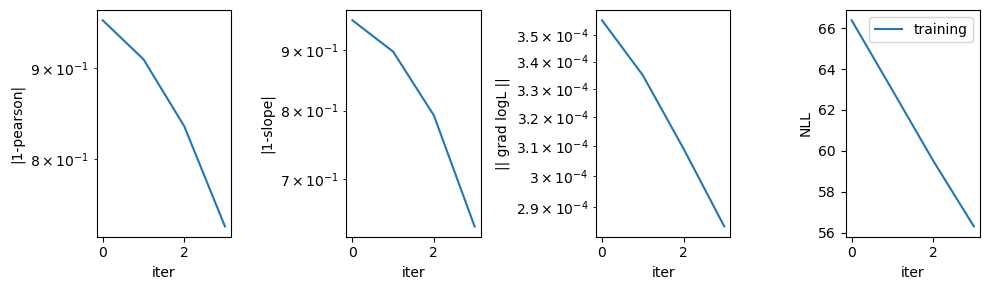

In [114]:
callbacks[0].plot();

POTTS


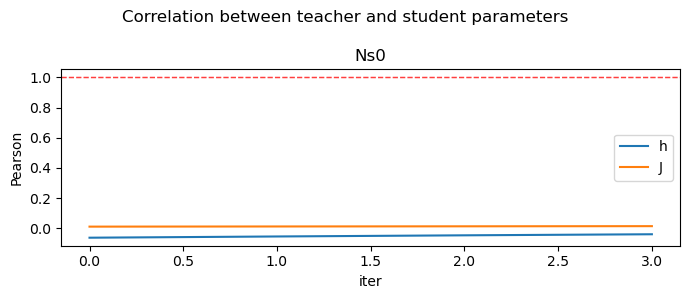

In [115]:
callbacks[1].plot(figsize=(7,3))
print('POTTS')

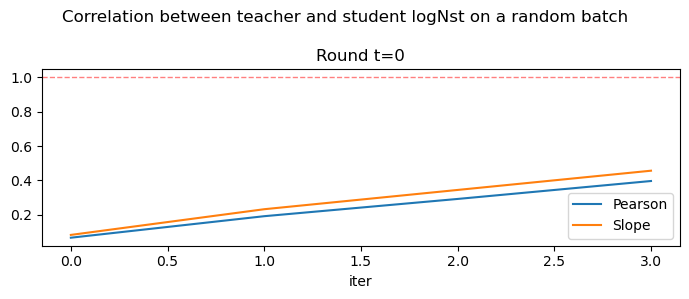

In [116]:
callbacks[1].plot_pearson_energies(figsize=(7,3));

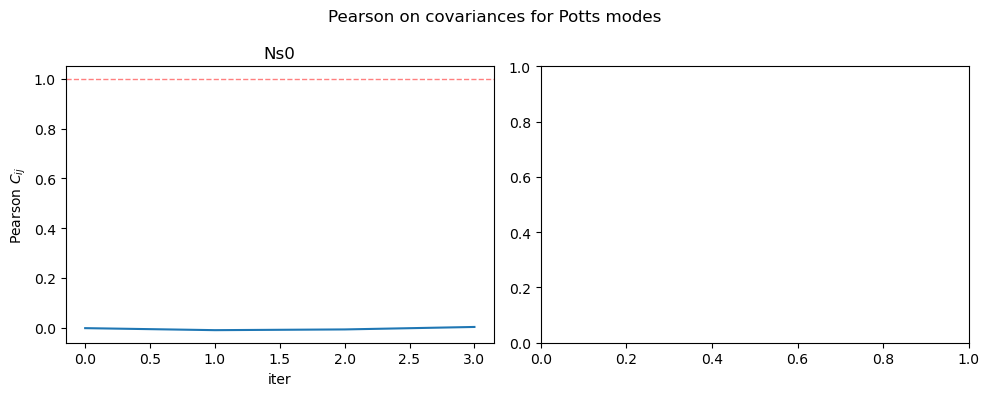

In [117]:
callbacks[2].plot();

In [ ]:
X = model.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

In [ ]:
X = model.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()

In [ ]:
X = model.selection.modes[0].set_zerosum_gauge().J.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().J.detach().reshape(-1)
plt.plot(Y, Y,ls='--', color='gray', alpha=1)
plt.scatter(X, Y)
torch.corrcoef(torch.stack([X,Y]))[0,1].item()